# Introduction: Automated Feature Engineering Basics(基本)

このノートブックでは、featuretoolsライブラリを使用して、自動機能エンジニアリングを[Home Credit Default Riskデータセット](https://www.kaggle.com/c/home-credit-default-risk)に適用する手順を説明します。 [Featuretools](https://docs.featuretools.com/)は、構造化された関連データの複数のテーブルから新しい機能を自動的に作成するためのオープンソースのPythonパッケージです。 これは、トレーニング用に（およびテスト用に）単一のデータフレームに結合する必要のある関連テーブルがいくつかあるホームクレジットデフォルトリスク競争などの問題に理想的なツールです。
## Feature Engineering

[特徴工学](https://en.wikipedia.org/wiki/Feature_engineering)の目的は、データセット全体からできるだけ多くの情報を1つのテーブルに表す新しい特徴（外植変数または予測変数と呼ばれる）を作成することです。通常、このプロセスは、 `groupby`、` agg`、または `merge`などのパンダ操作を使用して手動で実行され、非常に面倒な場合があります。さらに、手動の特徴エンジニアリングは、人間の時間の制約と想像力の両方によって制限されます。有用なすべての可能な特徴を想像することはできません。 （手動の特徴エンジニアリングの使用例については、[パート1](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)と[パート2](https：// www .kaggle.com / willkoehrsen / Introduction-to-manual-feature-engineering-p2)がこのコンテストに適用されます）。機械学習モデルは、提供されたデータからしか学習できないため、適切な機能を作成することの重要性を誇張することはできません。効果的なソリューションを作成するには、利用可能なデータセットから可能な限り多くの情報を抽出することが重要です。

[自動機能エンジニアリング](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)は、データセットから数百または数千の新しい機能を自動的に構築することにより、データサイエンティストが機能作成の問題を解決できるようにすることを目的としています。 。 現時点で自動機能エンジニアリング用の唯一のライブラリであるFeaturetoolsは、データサイエンティストに取って代わるものではありませんが、堅牢なモデルを本番環境に提供するなど、機械学習パイプラインのより価値のある部分に集中することができます。

ここでは、featuretoolsを使用した自動機能エンジニアリングの概念に触れ、ホームクレジットデフォルトリスクの競争にそれを実装する方法を示します。 基本に固執するので、アイデアを理解し、後で機能ツールをカスタマイズするときにこの基盤に基づいて構築できます。 これはKaggleカーネルの機能の範囲外である計算集約型のジョブであるため、データのサブセットを処理します。 このノートブックで行った作業を行い、データセット全体でメソッドを実行した結果[ここで入手可能](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools)。 このノートブックの最後では、機能自体と、手作業で設計された機能と自動的に作成された機能のさまざまな組み合わせを使用したモデリングの結果について説明します。

このコンテストに初めて参加する場合は、[開始するにはこの投稿](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)を確認することをお勧めします。 機能が非常に重要である理由をよく理解するために、Featuretoolsの開発者の1人による[ブログ投稿](https://www.featurelabs.com/blog/secret-to-data-science-success/)をご覧ください。

In [1]:
# Uncomment and run if kernel does not already have featuretools
# !pip install featuretools

In [2]:
import cupy as cp
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats as st

from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_moons
from sklearn.feature_selection import mutual_info_classif


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from keras.layers import Dense, Dropout
from keras.models import Sequential

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

from tqdm import tqdm

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

from Modules import Modules

%matplotlib inline

print("OK\n")

OK



In [3]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Problem
ホームクレジットデフォルトリスク競争は、教師あり分類機械学習タスクです。 目的は、過去の財務および社会経済データを使用して、申請者がローンを返済できるかどうかを予測することです。 これは、標準の教師あり分類タスクです。

* __Supervised__：ラベルはトレーニングデータに含まれており、目標は、モデルをトレーニングして、特徴からラベルを予測する方法を学習することです。
* __Classification__：ラベルはバイナリ変数で、0（期限内にローンを返済します）、1（ローンの返済が困難になります）

## Dataset

データは、[ホームクレジット]（http://www.homecredit.net/about-us.aspx）によって提供されます。これは、銀行口座を持たない人々に提供されるクレジットライン（ローン）専用のサービスです。

7つの異なるデータファイルがあります。

* __application_train / application_test__：ホームクレジットでの各ローン申請に関する情報を含む主要なトレーニングおよびテストデータ。すべてのローンには独自の行があり、`SK_ID_CURR`によって識別されます。トレーニングアプリケーションデータには、0：ローンが返済され、1：ローンが返済されなかったことを示す「TARGET」が付属しています。
* __bureau__：他の金融機関からのクライアントの以前のクレジットに関するデータ。以前の各クレジットには、ビューローに独自の行があり、 `SK_ID_BUREAU`によって識別されます。アプリケーションデータの各ローンには、複数の以前のクレジットを含めることができます。
* __bureau_balance__：ビューローの以前のクレジットに関する月次データ。各行は前のクレジットの1か月であり、1つの前のクレジットには、クレジットの長さの月ごとに1つずつ、複数の行を含めることができます。
* __previous_application__：アプリケーションデータにローンがあるクライアントのホームクレジットでのローンの以前のアプリケーション。アプリケーションデータの現在の各ローンには、複数の以前のローンを含めることができます。以前の各アプリケーションには1つの行があり、機能`SK_ID_PREV`によって識別されます。
* __POS_CASH_BALANCE__：クライアントがホームクレジットで持っていた以前のPOSまたは現金ローンに関する月次データ。各行は、前のPOSまたは現金ローンの1か月であり、1つの前のローンには多くの行を含めることができます。
* __credit_card_balance__：クライアントがホームクレジットで持っていた以前のクレジットカードに関する月次データ。各行はクレジットカードの残高の1か月であり、1つのクレジットカードに複数の行を含めることができます。
* __installments_payment__：ホームクレジットでの以前のローンの支払い履歴。支払いが行われるたびに1つの行があり、支払いを逃すたびに1つの行があります。

下の図（Home Creditが提供）は、テーブルがどのように関連しているかを示しています。これは、featuretoolsで関係を定義する必要がある場合に非常に役立ちます。

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### Read in Data and Create Small Datasets
計算を実行可能にするために、完全なデータセットを読み取り、 `SK_ID_CURR`で並べ替え、最初の1000行のみを保持します。 後でスクリプトに変換して、データセット全体で実行できます。

In [4]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('./home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
app_test = pd.read_csv('./home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv('./home-credit-default-risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv('./home-credit-default-risk/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]
cash = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
credit = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
previous = pd.read_csv('./home-credit-default-risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
installments = pd.read_csv('./home-credit-default-risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

トレインセットとテストセットを一緒に結合しますが、セットを識別する別の列を追加します。 各データセットにまったく同じ手順を適用する必要があるため、これは重要です。 それらを結合して単一のデータフレームとして扱うのが最も安全です。

（これにより列車セットへのデータ漏洩が可能かどうか、およびこれらの機能作成操作を個別に適用する必要があるかどうかはわかりません。ご意見をいただければ幸いです。

In [5]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

# Featuretools Basics

[Featuretools]（https://docs.featuretools.com/#minute-quick-start）は、[詳細な機能の合成]（http ：//www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf）。 自動化された特徴エンジニアリングは、機械学習の多くのトピックと同様に、より単純なアイデアの基盤の上に構築された複雑な主題です。 これらのアイデアを一度に1つずつ確認することで、後でそれを最大限に活用できるようにする機能ツールについての理解を深めることができます。

途中で取り上げる概念がいくつかあります。

* [Entities and EntitySets](https://docs.featuretools.com/loading_data/using_entitysets.html)
* [Relationships between tables](https://docs.featuretools.com/loading_data/using_entitysets.html#adding-a-relationship)
* [Feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html): aggregations and transformations
* [Deep feature synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html)

# Entities and Entitysets

エンティティは単なるテーブル、またはパンダでは「データフレーム」です。観測値は行にあり、特徴は列にあります。 featuretoolsのエンティティには、要素が重複していない一意のインデックスが必要です。現在、一意のインデックス（それぞれ、 `SK_ID_CURR`、` SK_ID_BUREAU`、および `SK_ID_PREV`）を持つのは、` app`、 `bureau`、および`previous`のみです。他のデータフレームについては、 `make_index = True`を渡してから、インデックスの名前を指定する必要があります。エンティティは、各エントリが一意の時間で識別される時間インデックスを持つこともできます。 （どのデータにも日時はありませんが、月または日で指定された相対的な時間があり、時間変数として扱うことができます）。

[EntitySet]（https://docs.featuretools.com/loading_data/using_entitysets.html）は、テーブルとテーブル間の関係のコレクションです。これは、独自のメソッドと属性を持つデータ構造と考えることができます。 EntitySetを使用すると、複数のテーブルをグループ化して、個々のテーブルよりもはるかに高速に操作できます。

まず、すべてのデータを追跡するために、clientsという名前の空のエンティティセットを作成します。

In [6]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

次に、各エンティティまたはデータのテーブルを定義します。 データにインデックスがある場合はインデックスを渡す必要があり、ない場合は `make_index=True`を渡す必要があります。 Featuretoolsは変数のタイプを自動的に推測しますが、必要に応じてそれらを変更することもできます。 たとえば、整数として表されるカテゴリ変数がある場合は、featuretoolsに正しいタイプを知らせたい場合があります。

In [7]:
# Entities with a unique index
es = es.add_dataframe(dataframe_name = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.add_dataframe(dataframe_name = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.add_dataframe(dataframe_name = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.add_dataframe(dataframe_name = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.add_dataframe(dataframe_name = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.add_dataframe(dataframe_name = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

# Relationships

リレーションシップは、featuretoolsだけでなく、あらゆるリレーショナルデータベースの基本的な概念です。 1対多の関係を考える最良の方法は、親から子へのアナロジーです。 親は1人の個人ですが、複数の子供を持つことができます。 その後、子供は自分の子供を複数持つことができます。 _親テーブル_では、各個人に1つの行があります。 親テーブルの各個人は、_子テーブル_に複数の行を持つことができます。

例として、 `app`データフレームにはクライアントごとに1つの行（` SK_ID_CURR`）があり、`bureau`データフレームには各親（` SK_ID_CURR`）に対して複数の以前のローン（ `SK_ID_PREV`）があります。 したがって、`bureau`データフレームは`app`データフレームの子です。 各ローンには`bureau`に1つの行がありますが、` bureau_balance`には複数の月次レコードがあるため、`bureau`データフレームは`bureau_balance`の親になります。

In [8]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

         FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20
100002                 0                 0                 0                 0
100003                 0                 0                 0                 0
100004                 0                 0                 0                 0
100006                 0                 0                 0                 0
100007                 0                 0                 0                 0

Child: bureau, Child Variable: SK_ID_CURR

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
6158905      100002       6158905        Closed      currency 1
6158906      100002       6158906        Closed      currency 1
6158907      100002       6158907        Closed      currency 1
6158908      100002       6158908        Closed      currency 1
6158909      100002       6158909        Active      currency 1


`SK_ID_CURR`" 100002 "には、親テーブルに1つの行があり、子に複数の行があります。

2つのテーブルは、共有変数を介してリンクされています。 `app`と`bureau`データフレームは`SK_ID_CURR`変数によってリンクされ、`bureau`と`bureau_balance`データフレームは`SK_ID_BUREAU`とリンクされます。 関係の定義は比較的簡単であり、競合他社が提供する図は関係を確認するのに役立ちます。 関係ごとに、親変数と子変数を指定する必要があります。 合計すると、テーブル間には合計6つの関係があります。 以下では、6つの関係すべてを指定してから、それらをEntitySetに追加します。

In [9]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es, 'app', 'SK_ID_CURR', 'bureau', 'SK_ID_CURR')

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es, 'bureau', 'SK_ID_BUREAU', 'bureau_balance', 'SK_ID_BUREAU')

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es, 'app', 'SK_ID_CURR', 'previous', 'SK_ID_CURR')

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'cash', 'SK_ID_PREV')
r_previous_installments = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'installments', 'SK_ID_PREV')
r_previous_credit = ft.Relationship(es, 'previous', 'SK_ID_PREV', 'credit', 'SK_ID_PREV')

print(r_app_bureau, r_bureau_balance)

<Relationship: bureau.SK_ID_CURR -> app.SK_ID_CURR> <Relationship: bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU>


In [10]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  DataFrames:
    app [Rows: 2002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

少し高度な注意：親から子へのパスが複数ある[ダイアモンドグラフ]（https://en.wikipedia.org/wiki/Diamond_graph）を作成しないように注意する必要があります。 `SK_ID_CURR`を介して`app`と`cash`を直接リンクする場合; `SK_ID_PREV`を介した`previous`と`cash`; そして`app`と`previous`は`SK_ID_CURR`を介して、`app`から`cash`への2つのパスを作成しました。 これによりあいまいさが生じるため、代わりに、`app`を`previous`を介して`cash`にリンクする必要があります。 `SK_ID_PREV`を使用して、` previous`（親）と `cash`（子）の関係を確立します。 次に、 `SK_ID_CURR`を使用して、` app`（親）と `previous`（現在は子）の関係を確立します。 その後、featuretoolsは、複数のプリミティブをスタックすることにより、`previous`と`cash`の両方から派生した`app`に機能を作成できるようになります。

エンティティ内のすべてのエンティティは、相互に関連付けることができます。 理論的には、これにより任意のエンティティの特徴を計算できますが、実際には、トレーニング/テストに使用されるため、`app`データフレームの特徴のみを計算します。

# Feature Primitives

[機能プリミティブ]（https://docs.featuretools.com/automated_feature_engineering/primitives.html は、機能を作成するためにテーブルまたはテーブルのセットに適用される操作です。 これらは単純な計算を表しており、その多くは手動の特徴エンジニアリングですでに使用されており、互いに積み重ねて複雑な特徴を作成することができます。 機能プリミティブは、次の2つのカテゴリに分類されます。

* __Aggregation__：各親の子データポイントをグループ化し、平均、最小、最大、標準偏差などの統計を計算する関数。 例として、各クライアントの以前の最大融資額を計算します。 集計は、テーブル間の関係を使用して複数のテーブル間で機能します。
* __Transformation__：単一のテーブルの1つ以上の列に適用される操作。 例としては、列の絶対値を取得したり、1つのテーブルの2つの列の違いを見つけたりします。

featuretoolsで使用可能な機能プリミティブのリストを以下に表示できます。

In [11]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

name         type  dask_compatible  spark_compatible  \
0            median  aggregation            False             False   
1  time_since_first  aggregation            False             False   
2             trend  aggregation            False             False   
3  avg_time_between  aggregation            False             False   
4   time_since_last  aggregation            False             False   
5      percent_true  aggregation             True             False   
6               max  aggregation             True              True   
7               sum  aggregation             True              True   
8              mean  aggregation             True              True   
9              last  aggregation            False             False   

                                                                 description  \
0                      Determines the middlemost number in a list of values.   
1         Calculates the time elapsed since the first datetime (in seconds).   
2                                Calculates the trend of a column over time.   
3         Computes the average number of seconds between consecutive events.   
4  Calculates the time elapsed since the last datetime (default in seconds).   
5                                   Determines the percent of `True` values.   
6                       Calculates the highest value, ignoring `NaN` values.   
7                             Calculates the total addition, ignoring `NaN`.   
8                                 Computes the average for a list of values.   
9                                       Determines the last value in a list.   

                                                                                          valid_inputs  \
0                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
1                            <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
2  <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>, <ColumnSchema (Semant...   
3                            <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
4                            <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
5             <ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>   
6                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
7                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
8                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
9                                                                                       <ColumnSchema>   

  return_type  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None  
8        None  
9        None

In [12]:
primitives[primitives['type'] == 'transform'].head(10)

name       type  dask_compatible  spark_compatible  \
22          cum_count  transform            False             False   
23        rolling_max  transform            False             False   
24   not_equal_scalar  transform             True              True   
25           latitude  transform            False             False   
26  modulo_by_feature  transform             True              True   
27               diff  transform            False             False   
28         url_to_tld  transform            False             False   
29            cum_sum  transform            False             False   
30   subtract_numeric  transform             True             False   
31               hour  transform             True              True   

                                                        description  \
22                                 Calculates the cumulative count.   
23           Determines the maximum of entries over a given window.   
24  Determines if values in a list are not equal to a given scalar.   
25       Returns the first tuple value in a list of LatLong tuples.   
26       Return the modulo of a scalar by each element in the list.   
27       Compute the difference between the value in a list and the   
28                        Determines the top level domain of a url.   
29                                   Calculates the cumulative sum.   
30                           Element-wise subtraction of two lists.   
31                         Determines the hour value of a datetime.   

                                                                                           valid_inputs  \
22      <ColumnSchema (Semantic Tags = ['foreign_key'])>, <ColumnSchema (Semantic Tags = ['category'])>   
23  <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>, <ColumnSchema (Semant...   
24                                                                                       <ColumnSchema>   
25                                                              <ColumnSchema (Logical Type = LatLong)>   
26                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
27                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
28                                                                  <ColumnSchema (Logical Type = URL)>   
29                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
30                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
31                                                             <ColumnSchema (Logical Type = Datetime)>   

   return_type  
22        None  
23        None  
24        None  
25        None  
26        None  
27        None  
28        None  
29        None  
30        None  
31        None

In [13]:
es['app'].head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
100002      100002     1.0         Cash loans           M            N   
100003      100003     0.0         Cash loans           F            N   
100004      100004     0.0    Revolving loans           M            Y   
100006      100006     0.0         Cash loans           F            N   
100007      100007     0.0         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
100002               Y             0          202500.0    406597.5   
100003               N             0          270000.0   1293502.5   
100004               Y             0           67500.0    135000.0   
100006               Y             0          135000.0    312682.5   
100007               Y             0          121500.0    513000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
100002      24700.5  ...                 0                0                0   
100003      35698.5  ...                 0                0                0   
100004       6750.0  ...                 0                0                0   
100006      29686.5  ...                 0                0                0   
100007      21865.5  ...                 0                0                0   

       AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
100002                        0.0                       0.0   
100003                        0.0                       0.0   
100004                        0.0                       0.0   
100006                        NaN                       NaN   
100007                        0.0                       0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
100002                        0.0                        0.0   
100003                        0.0                        0.0   
100004                        0.0                        0.0   
100006                        NaN                        NaN   
100007                        0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR    set  
100002                        0.0                         1.0  train  
100003                        0.0                         0.0  train  
100004                        0.0                         0.0  train  
100006                        NaN                         NaN  train  
100007                        0.0                         0.0  train  

[5 rows x 123 columns]

# Deep Feature Synthesis

Deep Feature Synthesis（DFS）は、featuretoolsが新しい機能を作成するために使用するプロセスです。 DFSスタックは、プリミティブの数に等しい「深さ」を持つフィーチャを形成するために、フィーチャプリミティブをスタックします。たとえば、クライアントの以前のローンの最大値（たとえば、 `MAX（previous.loan_amount）`）を取得すると、それは深さ1の「深い特徴」です。深さ2の特徴を作成するには、以前のローンごとのクライアントの月々の平均支払いの最大値（ `MAX（previous（MEAN（installments.payment）））`など）を取得することにより、プリミティブをスタックできます。 [深い特徴合成を使用した自動特徴工学に関する元の論文] （https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf は一読の価値があります。

featuretoolsでDFSを実行するには、 `dfs`関数を使用して、` entityset`、 `target_entity`（機能を作成する場所）、使用する` agg_primitives`、使用する `trans_primitives`、および`を渡します。機能のmax_depth`。ここでは、デフォルトの集約および変換プリミティブ（最大深度2）を使用し、`app`エンティティのプリミティブを計算します。このプロセスは計算コストが高いため、 `features_only = True`を使用して関数を実行すると、機能のリストのみが返され、機能自体は計算されません。これは、拡張計算を開始する前に、結果の特徴を確認するのに役立ちます。

### DFS with Default Primitives

In [14]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, 
                       target_dataframe_name='app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, 
                       features_only=True)

print('%d Total Features' % len(feature_names))

2213 Total Features


データセット全体でこの呼び出しを実行して機能を作成することに興味がある場合は、スクリプトを作成しました[ここで](https://www.kaggle.com/willkoehrsen/feature-engineering-using-feature-tools) 残念ながら、これは操作の計算コストのため、Kaggleカーネルでは実行されません。 64GBのRAMを搭載したコンピューターを使用すると、この関数呼び出しには約24時間かかりました（大学の強力なコンピューティングセンターの規則に技術的に違反しているとは思いません）。 データセット全体を[ここ](https://www.kaggle.com/willkoehrsen/home-credit-default-risk-feature-tools/data) の`feature_matrix.csv`というファイルで利用できるようにしました。

機能のサブセットを生成するには、以下のコードセルを実行します。

In [15]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(
                                    entityset = es, 
                                    target_dataframe_name = 'app',
                                    trans_primitives = default_trans_primitives,
                                    agg_primitives=default_agg_primitives, 
                                    max_depth = 2, 
                                    features_only=False, 
                                    verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 2213 features
Elapsed: 00:05 | Progress: 100%|██████████


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [16]:
feature_names[-20:]

[<Feature: STD(credit.previous.SELLERPLACE_AREA)>,
 <Feature: SUM(credit.previous.AMT_ANNUITY)>,
 <Feature: SUM(credit.previous.AMT_APPLICATION)>,
 <Feature: SUM(credit.previous.AMT_CREDIT)>,
 <Feature: SUM(credit.previous.AMT_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.AMT_GOODS_PRICE)>,
 <Feature: SUM(credit.previous.CNT_PAYMENT)>,
 <Feature: SUM(credit.previous.DAYS_DECISION)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DRAWING)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION)>,
 <Feature: SUM(credit.previous.DAYS_TERMINATION)>,
 <Feature: SUM(credit.previous.HOUR_APPR_PROCESS_START)>,
 <Feature: SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)>,
 <Feature: SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY)>,
 <Feature: SUM(credit.previous.RATE_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIMARY)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIVILEGED)>,
 <Feature:

### DFS with Selected Aggregation Primitives

featuretoolsを使用すると、数行のコードで121の元の機能からほぼ1700の機能に移行することができました。 手作業で特徴工学を行った場合、同等のサイズのデータセットを作成するのに約12時間かかりました。 ただし、featuretoolsには多くの機能がありますが、この関数呼び出しは十分な情報がありません。 問題にとって「重要」な集計を考慮せずに、デフォルトの集計を使用しただけです。 最終的には多くの機能が追加されますが、それらすべてが問題に関連しているとは限りません。 無関係な機能が多すぎると、重要な機能（[次元の呪い](https://en.wikipedia.org/wiki/Curse_of_dimensionit)に関連する）を溺死させてパフォーマンスを低下させる可能性があります）

次の呼び出しでは、機能のより小さなセットを指定します。 私たちはまだ多くのドメイン知識を使用していませんが、この機能セットはより管理しやすくなります。 ここからの次のステップは、実際に構築する特徴を改善し、特徴選択を実行することです。

In [17]:
# Specify the aggregation primitives
feature_matrix_spec, feature_names_spec = ft.dfs(
    entityset = es, 
    target_dataframe_name = 'app',  
    agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
    max_depth = 2, features_only = False, verbose = True
)

Built 1211 features
Elapsed: 00:01 | Progress: 100%|██████████


その「のみ」は、884個の機能を提供します（完全なデータセットで実行するには約12時間かかります）。

In [18]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

## Notes on Basic Implementation

これらの呼び出しは、[featuretoolsの機能のごく一部](https://docs.featuretools.com/guides/tuning_dfs.html)のみを表しています。 エンティティを作成するときに変数タイプを指定せず、相対時間変数を使用せず、[カスタムプリミティブ](https://docs.featuretools.com/guides/advanced_custom_primitives.html)またはシード機能に触れませんでした。 面白い値！ それでも、このノートブックでは、ツールがどのように機能するかを学びながら、ツールをより効果的に使用できるようにするための基本的な基礎を学ぶことができました。 それでは、私たちが構築した機能のいくつかとモデリング結果を見てみましょう。

# Results

機能ツールの基本的な実装が有用であったかどうかを判断するために、いくつかの結果を見ることができます。

*いくつかの異なる機能セットを使用した相互検証スコアとパブリックリーダーボードスコア。
*相関関係：機能と `TARGET`の間、および機能自体の間の両方
*機能の重要性：勾配ブースティングマシンモデルによって決定されます


## Feature Performance Experiments

機械学習タスクのさまざまな機能セットを比較するために、いくつかの実験を設定しました。機能の効果を分離するために、同じモデルを使用してさまざまな機能セットをテストしました。モデル（付録で見ることができます）は、トレーニングと評価のために5分割交差検証を使用する基本的なLightGBMアルゴリズムです。まず、コントロールデータセットを確立し、次に一連の実験を実行して結果を提示します。

### 制御：`application`データセットからのデータのみを使用
* テスト1： `application`、` bureau`、`bureau_balance`データのみを使用した手動の特徴エンジニアリング
* テスト2：すべてのデータセットを使用した手動の特徴エンジニアリング
* テスト3：featuretoolsのデフォルト機能（ `feature_matrix`内）
* テスト4：featuretoolsで指定された機能（ `feature_matrix_spec`内）
* テスト5：手動の特徴エンジニアリングと組み合わせたfeaturetools指定の機能

機能の数はワンホットエンコーディング後、曲線下の検証受信者動作特性領域（ROC AUC）は5分割交差検証を使用して計算され、テストROC AUCはパブリックリーダーボードからのものであり、設計に費やされた時間は私のデータセットの作成にかかった時間の最良の見積もり！

| Test    | Number of Features | Validation ROC AUC | Test ROC AUC | Time Spent |
|---------|--------------------|--------------------|--------------|--------|
| Control | 241                |           0.760         |     0.745         |       0.25 hours  |
| One     | 421                |       0.766             |      0.757        |        8 hours        |
| Two     |      1465             |          0.785          |         0.783     |                 12 hours |
| Three   | 1803               |      0.784              |       0.777       |               1 hour
| Four    | 1156               |         0.786           |        0.779      |                 1.25 hours |
| Five    |  1624                  |           0. 787        |      0.782        |                    13.25 hours |


どのセットが正確に最適であるかを判断するのは難しいですが（クロス検証スコアはパブリックリーダーボードよりも信頼できますが）、開発の時期には大きな違いがあります。 指定されたfeaturetoolsデータセットは、8％の時間を費やして、テストセットで手動で設計された機能とほぼ同じパフォーマンスを達成することができました。 featuretoolsがこの問題に価値をもたらしたことは明らかですが、それでも仕事がないわけではありません。 データサイエンティストの重要な役割は、プリミティブの正しいセットを選択し、すべての候補の中から最適な機能を選択することです。

## Correlations

次に、データ内の相関関係を確認できます。ターゲットとの相関関係を見るときは、[多重比較の問題](https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578)に注意する必要があります。ランダムノイズのために、ターゲットと相関している可能性があります。 「良い特徴」を特定するための最初の近似として相関を使用することは問題ありませんが、厳密な特徴選択方法ではありません。

また、いくつかの機能を調べたところ、featuretoolsによって作成された[機能間の共線性](https://en.wikipedia.org/wiki/Multicollinearity)に問題があるようです。相互に高度に相関している機能は、テストセットの解釈可能性と一般化のパフォーマンスを低下させる可能性があります。理想的なシナリオでは、一連の独立した機能がありますが、実際にはそれが発生することはめったにありません。非常に相関性の高い変数がある場合は、それらのいくつかを削除することを検討することをお勧めします。

相関関係については、プリミティブを指定して作成した機能である`feature_matrix_spec`に焦点を当てます。同じ分析をデフォルトの機能セットに適用できます。これらの相関関係は、機能マトリックスのトレーニングセクション全体を使用して計算されました。

In [19]:
correlations = pd.read_csv('./home-credit-default-risk-feature-tools/correlations_spec.csv', index_col = 0)
correlations.index.name = 'Variable'
correlations.head()

SK_ID_CURR  FLAG_EMP_PHONE  \
Variable                                                  
SK_ID_CURR                     1.000000       -0.001337   
FLAG_EMP_PHONE                -0.001337        1.000000   
DEF_60_CNT_SOCIAL_CIRCLE       0.001187       -0.014034   
LIVE_REGION_NOT_WORK_REGION    0.002903        0.096447   
YEARS_BEGINEXPLUATATION_AVG    0.001551       -0.008672   

                             DEF_60_CNT_SOCIAL_CIRCLE  \
Variable                                                
SK_ID_CURR                                   0.001187   
FLAG_EMP_PHONE                              -0.014034   
DEF_60_CNT_SOCIAL_CIRCLE                     1.000000   
LIVE_REGION_NOT_WORK_REGION                 -0.016693   
YEARS_BEGINEXPLUATATION_AVG                 -0.004751   

                             LIVE_REGION_NOT_WORK_REGION  \
Variable                                                   
SK_ID_CURR                                      0.002903   
FLAG_EMP_PHONE                                  0.096447   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.016693   
LIVE_REGION_NOT_WORK_REGION                     1.000000   
YEARS_BEGINEXPLUATATION_AVG                     0.012031   

                             YEARS_BEGINEXPLUATATION_AVG  APARTMENTS_MODE  \
Variable                                                                    
SK_ID_CURR                                      0.001551         0.001961   
FLAG_EMP_PHONE                                 -0.008672         0.014720   
DEF_60_CNT_SOCIAL_CIRCLE                       -0.004751        -0.015337   
LIVE_REGION_NOT_WORK_REGION                     0.012031         0.017831   
YEARS_BEGINEXPLUATATION_AVG                     1.000000         0.100665   

                             FLAG_MOBIL  FLOORSMIN_MEDI  BASEMENTAREA_AVG  \
Variable                                                                    
SK_ID_CURR                     0.002804        0.002837         -0.002070   
FLAG_EMP_PHONE                -0.000845        0.016486          0.001292   
DEF_60_CNT_SOCIAL_CIRCLE       0.000499       -0.020663         -0.012925   
LIVE_REGION_NOT_WORK_REGION    0.000371        0.053927          0.000965   
YEARS_BEGINEXPLUATATION_AVG   -0.000649        0.166756          0.085950   

                             LANDAREA_MODE  FLAG_DOCUMENT_21  AMT_GOODS_PRICE  \
Variable                                                                        
SK_ID_CURR                        0.001548          0.000282        -0.000232   
FLAG_EMP_PHONE                    0.008657          0.008579         0.063487   
DEF_60_CNT_SOCIAL_CIRCLE         -0.002882          0.000393        -0.024506   
LIVE_REGION_NOT_WORK_REGION      -0.006717         -0.001969         0.052864   
YEARS_BEGINEXPLUATATION_AVG       0.070008         -0.000052         0.007245   

                             COMMONAREA_MODE  APARTMENTS_MEDI  EXT_SOURCE_1  \
Variable                                                                      
SK_ID_CURR                         -0.001058         0.001988      0.000082   
FLAG_EMP_PHONE                      0.013112         0.016323     -0.294147   
DEF_60_CNT_SOCIAL_CIRCLE           -0.012114        -0.015995     -0.030508   
LIVE_REGION_NOT_WORK_REGION         0.028017         0.018141     -0.031389   
YEARS_BEGINEXPLUATATION_AVG         0.086286         0.100132      0.002120   

                             EXT_SOURCE_3  FLAG_DOCUMENT_16  \
Variable                                                      
SK_ID_CURR                       0.000222         -0.000724   
FLAG_EMP_PHONE                  -0.115293          0.043008   
DEF_60_CNT_SOCIAL_CIRCLE        -0.034096         -0.005927   
LIVE_REGION_NOT_WORK_REGION     -0.029603          0.004296   
YEARS_BEGINEXPLUATATION_AVG     -0.000406         -0.000992   

                             LIVINGAPARTMENTS_MODE  ENTRANCES_MEDI  \
Variable                                                             
SK_ID_CURR

### Correlations with the Target

In [20]:
correlations_target = correlations.sort_values('TARGET')['TARGET']
# Most negative correlations
correlations_target.head()

Variable
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed      -0.070201
NAME_EDUCATION_TYPE_Higher education   -0.056593
Name: TARGET, dtype: float64

In [21]:
# Most positive correlations
correlations_target.dropna().tail()

Variable
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, dtype: float64

featuretoolsによって作成された機能のいくつかは、（絶対等級の観点から）`TARGET`と最も相関しています。 ただし、それは必ずしも「重要」であるという意味ではありません。


### Visualize Distribution of Correlated Variables

結果の特徴とそれらのターゲットとの関係を確認する1つの方法は、カーネル密度推定プロットを使用することです。 これは、単一の変数の分布を示しており、平滑化されたヒストグラムと考えることができます。 数値変数の分布に対するカテゴリ変数の影響を示すために、カテゴリ変数の値でプロットに色を付けることができます。 以下のプロットでは、ターゲットの値によって色分けされた、新しく作成された2つのフィーチャの分布を示しています。

まず、pandasの`read_csv`関数の`nrows`引数を使用して、機能マトリックスの一部を読み込みます。 これにより、2GBのファイル全体が読み込まれないようになります。

In [22]:
features_sample = pd.read_csv('./home-credit-default-risk-feature-tools/feature_matrix.csv', nrows = 20000)
features_sample = features_sample[features_sample['set'] == 'train']
features_sample.head()

SK_ID_CURR NAME_TYPE_SUITE  REG_REGION_NOT_LIVE_REGION  EXT_SOURCE_2  \
1      100002   Unaccompanied                           0      0.262949   
2      100003          Family                           0      0.622246   
3      100004   Unaccompanied                           0      0.555912   
5      100006   Unaccompanied                           0      0.650442   
6      100007   Unaccompanied                           0      0.322738   

  OCCUPATION_TYPE  FLAG_PHONE  AMT_INCOME_TOTAL  AMT_CREDIT  \
1        Laborers           1          202500.0    406597.5   
2      Core staff           1          270000.0   1293502.5   
3        Laborers           1           67500.0    135000.0   
5        Laborers           0          135000.0    312682.5   
6      Core staff           0          121500.0    513000.0   

   REGION_RATING_CLIENT  REG_REGION_NOT_WORK_REGION  CNT_FAM_MEMBERS  \
1                     2                           0              1.0   
2                     1                           0              2.0   
3                     2                           0              1.0   
5                     2                           0              2.0   
6                     2                           0              1.0   

   DAYS_BIRTH  REG_CITY_NOT_LIVE_CITY  COMMONAREA_AVG  FLAG_WORK_PHONE  \
1       -9461                       0          0.0143                0   
2      -16765                       0          0.0605                0   
3      -19046                       0             NaN                1   
5      -19005                       0             NaN                0   
6      -19932                       0             NaN                0   

   HOUSETYPE_MODE  FLAG_DOCUMENT_21  ELEVATORS_AVG  LIVINGAPARTMENTS_MODE  \
1  block of flats                 0           0.00                  0.022   
2  block of flats                 0           0.08                  0.079   
3             NaN                 0            NaN                    NaN   
5             NaN                 0            NaN                    NaN   
6             NaN                 0            NaN                    NaN   

     set  FLOORSMAX_MODE  FLAG_DOCUMENT_17  AMT_REQ_CREDIT_BUREAU_QRT  \
1  train          0.0833                 0                        0.0   
2  train          0.2917                 0                        0.0   
3  train             NaN                 0                        0.0   
5  train             NaN                 0                        NaN   
6  train             NaN                 0                        0.0   

   COMMONAREA_MEDI  FLAG_EMAIL  FLAG_DOCUMENT_5       ORGANIZATION_TYPE  \
1           0.0144           0                0  Business Entity Type 3   
2           0.0608           0                0                  School   
3              NaN           0                0              Government   
5              NaN           0                0  Business Entity Type 3   
6              NaN           0                0                Religion   

  FLAG_OWN_REALTY  DAYS_REGISTRATION  DAYS_ID_PUBLISH  LANDAREA_MODE  \
1               Y            -3648.0            -2120         0.0377   
2               N            -1186.0             -291         0.0128   
3               Y            -4260.0            -2531            NaN   
5               Y            -9833.0            -2437            NaN   
6               Y            -4311.0            -3458            NaN   

   NONLIVINGAPARTMENTS_MEDI  FLAG_DOCUMENT_15  REGION_POPULATION_RELATIVE  \
1                    0.0000                 0                    0.018801   
2                    0.0039                 0                    0.003541   
3                       NaN                 0                    0.010032   
5                       NaN                 0                    0.008019   
6                       NaN                 0                    0.028663   

   LIVE_REGION_NOT_WORK_REGION  LIVINGAREA_MED

In [23]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

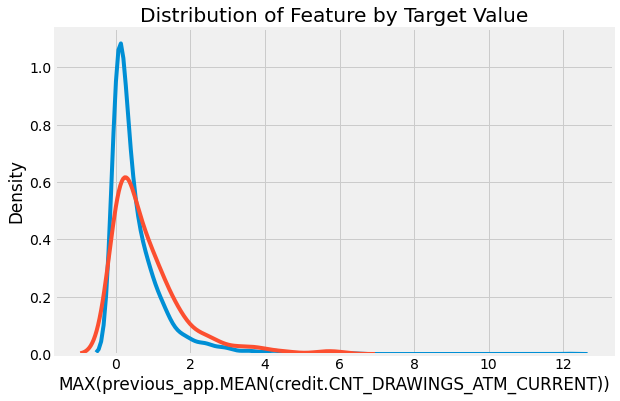

In [24]:
kde_target_plot(features_sample, feature = 'MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))')

この機能とターゲットの間の相関は非常に弱く、ノイズのみである可能性があります。 この機能を解釈しようとするのは難しいですが、私の推測では、以前のクレジットカードローンでの1か月あたりの平均ATM図面数のクライアントの最大値です。 （機能のサンプルのみを使用しているため、これはデータセット全体を表すものではない可能性があります）。

調査するもう1つの領域は、同一線上の特徴として知られる、相関性の高い特徴です。 相関する特徴のペアを探し、しきい値を超えるものを削除できる可能性があります。

#### Collinear Features

In [25]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [26]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))']

In [27]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

Variable
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                       1.000000
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    0.999382
MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.999024
MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995957
SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995484
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

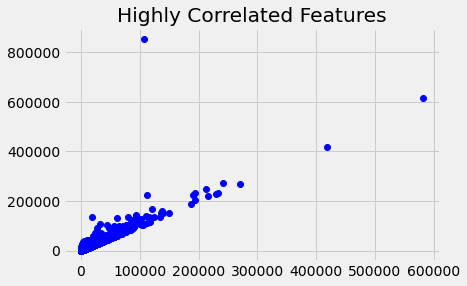

In [28]:
plt.plot(features_sample['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'], features_sample['MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))'], 'bo')
plt.title('Highly Correlated Features');

これらの変数はすべて互いに0.99の相関関係があり、ほぼ完全に正の線形です。 冗長な情報をエンコードするため、これらすべてをモデルに含める必要はありません。 モデルの学習と一般化を改善するために、これらの相関性の高い変数の一部を削除することをお勧めします。

## Feature Importances

ツリーベースのモデルによって返される機能の重要性[不純物の減少を表す](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined) モデル。 重要度の絶対値を解釈するのは難しい場合がありますが、重要度の相対値を調べることで、機能の関連性を比較できます。 特徴の重要性に過度の価値を置くことに注意したいのですが、それらは次元削減とモデルの理解に役立つ方法です。

In [29]:
# Read in the feature importances and sort with the most important at the top
fi = pd.read_csv('./home-credit-default-risk-feature-tools/spec_feature_importances_ohe.csv', index_col = 0)
fi = fi.sort_values('importance', ascending = False)
fi.head(50)

feature  importance
13                                          EXT_SOURCE_1       357.6
14                                          EXT_SOURCE_3       311.6
58                                          EXT_SOURCE_2       307.0
31                                            DAYS_BIRTH       228.6
55                                            AMT_CREDIT       204.4
91                                           AMT_ANNUITY       195.2
69                                         DAYS_EMPLOYED       150.2
10                                       AMT_GOODS_PRICE       144.2
186                              MAX(bureau.DAYS_CREDIT)       138.8
42                                       DAYS_ID_PUBLISH       122.8
115                      MAX(bureau.DAYS_CREDIT_ENDDATE)       121.8
62                                           OWN_CAR_AGE       104.0
518      SUM(previous_app.MIN(installments.AMT_PAYMENT))       101.8
196                        MAX(bureau.DAYS_ENDDATE_FACT)        99.6
669     MEAN(previous_app.MIN(installments.AMT_PAYMENT))        99.0
351                        MIN(installments.AMT_PAYMENT)        98.0
130                     MEAN(bureau.AMT_CREDIT_SUM_DEBT)        93.0
51                                     DAYS_REGISTRATION        92.6
22                                DAYS_LAST_PHONE_CHANGE        86.4
686                       MEAN(previous_app.COUNT(cash))        82.8
129                           MAX(bureau.AMT_CREDIT_SUM)        81.6
639  MEAN(previous_app.MEAN(cash.CNT_INSTALMENT_FUTURE))        79.8
43                            REGION_POPULATION_RELATIVE        72.8
259                             MEAN(bureau.DAYS_CREDIT)        70.6
235                 MAX(installments.DAYS_ENTRY_PAYMENT)        69.8
234                          MEAN(bureau.AMT_CREDIT_SUM)        67.2
174                           MIN(bureau.AMT_CREDIT_SUM)        67.0
233                      SUM(bureau.DAYS_CREDIT_ENDDATE)        62.8
181           MEAN(previous_app.HOUR_APPR_PROCESS_START)        62.6
349                           SUM(bureau.AMT_CREDIT_SUM)        61.0
231                  MEAN(bureau.AMT_CREDIT_MAX_OVERDUE)        58.2
126                       MAX(bureau.DAYS_CREDIT_UPDATE)        56.8
291                       MEAN(previous_app.CNT_PAYMENT)        55.6
171                  MEAN(previous_app.SELLERPLACE_AREA)        55.6
114                   SUM(previous_app.AMT_DOWN_PAYMENT)        55.6
413   MAX(previous_app.MEAN(cash.CNT_INSTALMENT_FUTURE))        53.8
85                                      AMT_INCOME_TOTAL        53.4
248                  MAX(previous_app.RATE_DOWN_PAYMENT)        52.2
156                     MEAN(bureau.DAYS_CREDIT_ENDDATE)        49.8
816               MEAN(previous_app.COUNT(installments))        48.4
228                      SUM(bureau.AMT_CREDIT_SUM_DEBT)        47.8
162                       MEAN(bureau.DAYS_ENDDATE_FACT)        46.8
760   MEAN(previous_app.MIN(cash.CNT_INSTALMENT_FUTURE))        44.4
185                      MEAN(bureau.DAYS_CREDIT_UPDATE)        44.4
330                   MAX(previous_app.AMT_DOWN_PAYMENT)        44.4
926                                        CODE_GENDER_F        44.2
243                    MIN(previous_app.AMT_GOODS_PRICE)        43.6
947                           NAME_FAMILY_STATUS_Married        43.4
124                       MEAN(previous_app.AMT_ANNUITY)        43.0
301                      MAX(bureau.AMT_CREDIT_SUM_DEBT)        42.0

featuretoolsによって作成された最も重要な機能は、クライアントが別の機関でローンを申請した現在の申請までの最大日数でした。 （この機能は元々負として記録されているため、最大値はゼロに最も近くなります）。

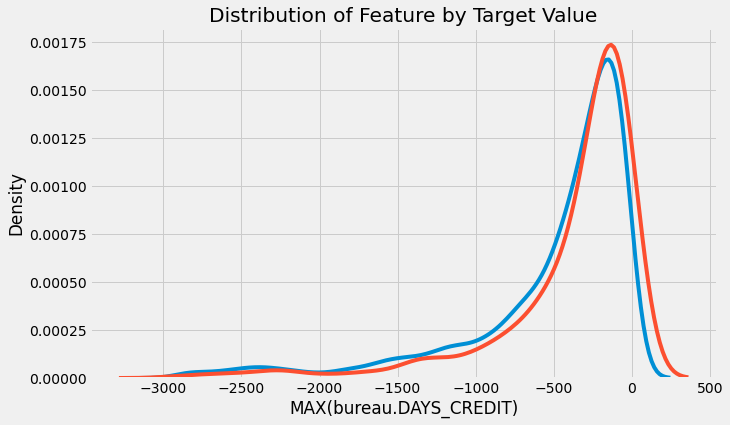

In [30]:
kde_target_plot(features_sample, feature = 'MAX(bureau.DAYS_CREDIT)')

featuretoolsによって作成された上位100の機能の数を計算できます。

In [31]:
# List of the original features (after one-hot)
original_features = list(pd.get_dummies(app).columns)

created_features = []

# Iterate through the top 100 features
for feature in fi['feature'][:100]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 100 features were made by featuretools' % len(created_features))

78 of the top 100 features were made by featuretools


15の最も重要な機能を視覚化するための短い関数を書いてみましょう。

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Parameters
    --------
        df : dataframe
            feature importances. Must have the features in a column
            called `features` and the importances in a column called `importance
        
    Return
    -------
        shows a plot of the 15 most importance features
        
        df : dataframe
            feature importances sorted by importance (highest to lowest) 
            with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 10))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

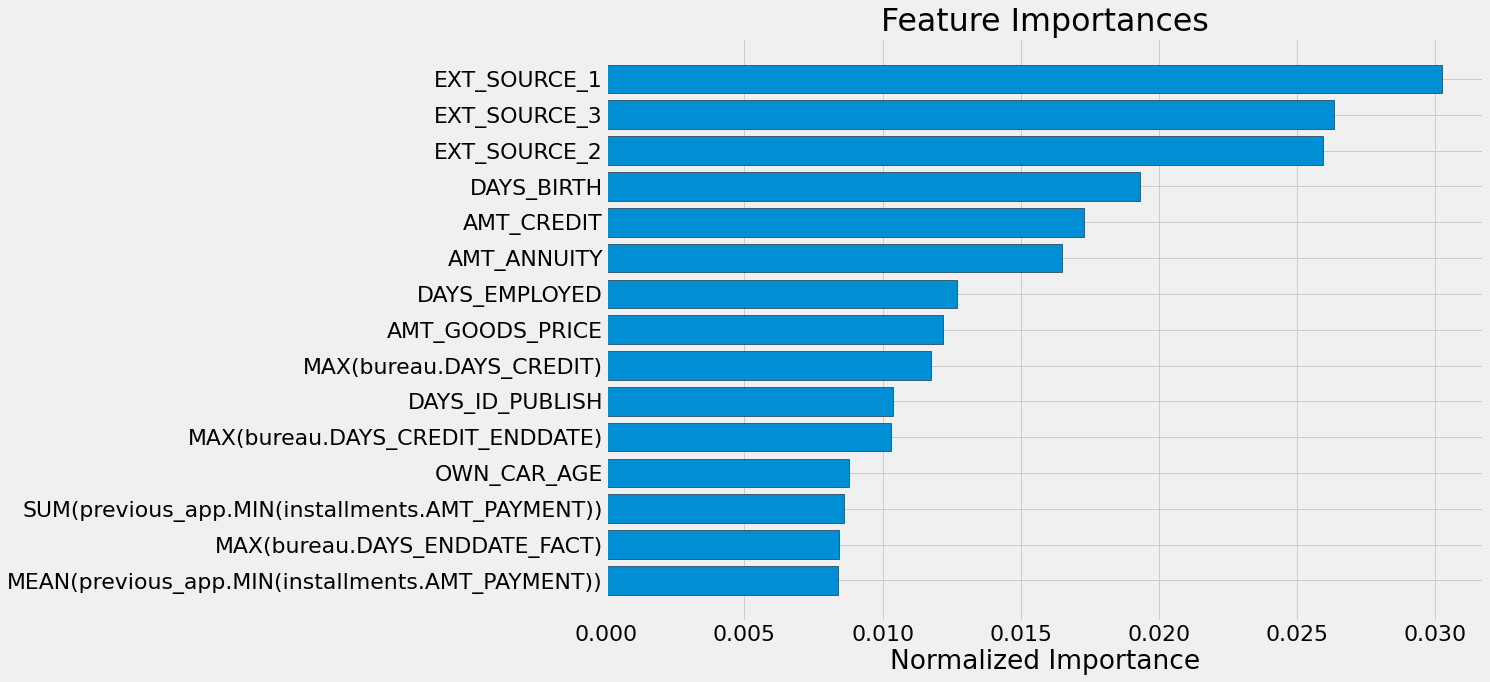

In [33]:
fi = plot_feature_importances(fi)

featuretoolsによって作成された最も重要な機能は`MAX（bureau.DAYS_CREDIT）`でした。 `DAYS_CREDIT`は、申請者が別の信用機関でローンを申請した、ホームクレジットでの現在の申請までの日数を表します。 したがって、この値の最大値（以前のローンに対する）は、この機能によって表されます。 また、「MEAN（previous_app.MIN（installments.AMT_PAYMENT））」など、深さが2の重要な機能がいくつかあります。これは、以前のクレジットアプリケーションの分割払いの最小値のクライアントのローンの平均です。

機能の重要度は、次元削減に使用できます。 また、問題をよりよく理解するために使用することもできます。 たとえば、潜在的なローンを評価するときにクライアントのこれらの側面に集中するために、最も重要な機能を使用できます。 重要度が0で、機能セットからほぼ確実に削除できる機能の数を見てみましょう。

In [34]:
print('There are %d features with 0 importance' % sum(fi['importance'] == 0.0))

There are 237 features with 0 importance


## Remove Low Importance Features

特徴選択はそれ自体がトピック全体ですが、私たちができることの1つは、一意の値が1つしかない、またはすべてnullである特徴を削除することです。 Featuretoolsには、これを行うためのデフォルトのメソッドが`selection`モジュールで利用可能です。

In [35]:
from featuretools import selection

# Remove features with only one unique value
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('Removed %d features' % (feature_matrix.shape[1]- feature_matrix2.shape[1]))

Removed 369 features


## Align Train and Test Sets

また、トレインセットとテストセットがまったく同じ機能を備えていることを確認する必要があります。 最初にデータをワンホットエンコードし（モデルではとにかくこれを行う必要があります）、次にデータフレームを列に配置します。

In [36]:
# Separate out the train and test sets
train = feature_matrix2[feature_matrix2['set'] == 'train']
test = feature_matrix2[feature_matrix2['set'] == 'test']

# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Align dataframes on the columns
train, test = train.align(test, join = 'inner', axis = 1)
test = test.drop(columns = ['TARGET'])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (1001, 2156)
Final Testing Shape:  (1001, 2155)


In [37]:
train.head()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                                    
100002         1.0             0          202500.0    406597.5      24700.5   
100003         0.0             0          270000.0   1293502.5      35698.5   
100004         0.0             0           67500.0    135000.0       6750.0   
100006         0.0             0          135000.0    312682.5      29686.5   
100007         0.0             0          121500.0    513000.0      21865.5   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             351000.0                    0.018801       -9461   
100003            1129500.0                    0.003541      -16765   
100004             135000.0                    0.010032      -19046   
100006             297000.0                    0.008019      -19005   
100007             513000.0                    0.028663      -19932   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002               -637            -3648.0            -2120          NaN   
100003              -1188            -1186.0             -291          NaN   
100004               -225            -4260.0            -2531         26.0   
100006              -3039            -9833.0            -2437          NaN   
100007              -3038            -4311.0            -3458          NaN   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                   1                0                 1           1   
100003                   1                0                 1           1   
100004                   1                1                 1           1   
100006                   1                0                 1           0   
100007                   1                0                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002               0              1.0                     2   
100003               0              2.0                     1   
100004               0              1.0                     2   
100006               0              2.0                     2   
100007               0              1.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                                2                       10   
100003                                1                       11   
100004                                2                        9   
100006                                2                       17   
100007                                2                       11   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                               0                           0   
100003                               0                           0   
100004                               0                           0   
100006                               0                           0   
100007                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100002                                0                       0   
100003                                0                       0   
100004                                0                       0   
100006                                0                       0   
100007                                0        

In [38]:
test.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100001                 0          135000.0    568800.0      20560.5   
100005                 0           99000.0    222768.0      17370.0   
100013                 0          202500.0    663264.0      69777.0   
100028                 2          315000.0   1575000.0      49018.5   
100038                 1          180000.0    625500.0      32067.0   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100001             450000.0                    0.018850      -19241   
100005             180000.0                    0.035792      -18064   
100013             630000.0                    0.019101      -20038   
100028            1575000.0                    0.026392      -13976   
100038             625500.0                    0.010032      -13040   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100001              -2329            -5170.0             -812          NaN   
100005              -4469            -9118.0            -1623          NaN   
100013              -4458            -2175.0            -3503          5.0   
100028              -1866            -2000.0            -4208          NaN   
100038              -2191            -4000.0            -4262         16.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100001                   1                0                 1           0   
100005                   1                0                 1           0   
100013                   1                0                 1           0   
100028                   1                0                 1           1   
100038                   1                1                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100001               1              2.0                     2   
100005               0              2.0                     2   
100013               0              2.0                     2   
100028               0              4.0                     2   
100038               0              3.0                     2   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100001                                2                       18   
100005                                2                        9   
100013                                2                       14   
100028                                2                       11   
100038                                2                        5   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100001                               0                           0   
100005                               0                           0   
100013                               0                           0   
100028                               0                           0   
100038                               0                           0   

            LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                                                        
100001                                0                       0   
100005                                0                       0   
100013                                0                       0   
100028                                0                       0   
100038                                0                       0   

            REG_CITY_NOT_WORK_CITY 

情報量の少ない機能を削除し、データフレームを調整することで、1689の機能が残りました。 特徴ツールを使用する場合、特徴選択は確かに重要な役割を果たします。

 # Conclusions

このノートブックでは、ホームクレジットデフォルトリスクデータセットの機能ツールを使用した自動機能エンジニアリングの使用の基本的な実装について説明しました。 featuretoolsの高度な機能は使用しませんでしたが、相互検証およびテストセットでのモデルのパフォーマンスを向上させる便利な機能を作成することができました。さらに、自動化された特徴エンジニアリングは、同等の結果を提供しながら、手動の特徴エンジニアリングに費やされた時間のほんの一部を要しました。

__featuretoolsのデフォルトの機能セットでさえ、10％未満の時間で手動の機能と同様のパフォーマンスを達成することができました。__
__Featuretoolsは、データサイエンティストのツールボックスに含まれている場合、明らかに価値を高めます。__

次のステップは、機能ツールの高度な機能をドメイン知識と組み合わせて利用し、より便利な機能のセットを作成することです。 [今後のノートブックでの機能ツールの調整](https://www.kaggle.com/willkoehrsen/intro-to-tuning-automated-feature-engineering)を見ていきます。

## Appendix: GBM Model (Used Across Feature Sets)
```python
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, boosting_type = 'goss',
				   objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
```

## AUC

In [39]:
app_train = train.copy()
app_train = app_train.reset_index(inplace= False, drop=False)
app_train = app_train.reset_index(inplace= False, drop=True)
app_test = test.copy()
app_test = app_test.reset_index(inplace= False, drop=False)
app_test = app_test.reset_index(inplace= False, drop=True)
app_train.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002     1.0             0          202500.0    406597.5   
1      100003     0.0             0          270000.0   1293502.5   
2      100004     0.0             0           67500.0    135000.0   
3      100006     0.0             0          135000.0    312682.5   
4      100007     0.0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0           -637            -3648.0            -2120          NaN   
1          -1188            -1186.0             -291          NaN   
2           -225            -4260.0            -2531         26.0   
3          -3039            -9833.0            -2437          NaN   
4          -3038            -4311.0            -3458          NaN   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   
3           NaN      0.650442           NaN             NaN               NaN   
4           NaN      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          

In [40]:
### train
#app_train.to_csv(
#    path_or_buf="./home-credit-default-risk/exports/app_train_auto.csv", # 出力先
#    sep=",",                                            # 区切り文字
#    index=False,                                        # indexの出力有無
#    header=True                                        # headerの出力有無
#)

In [41]:
### test
#app_test.to_csv(
#    path_or_buf="./home-credit-default-risk/exports/app_test_auto.csv", # 出力先
#    sep=",",                                            # 区切り文字
#    index=False,                                        # indexの出力有無
#    header=True                                        # headerの出力有無
#)

In [42]:
data = pd.concat([app_train, app_test], sort=False)
train_data = data[:len(app_train)]
test_data = data[len(app_test):]

y_train = train_data['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [43]:
y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)


params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    ,'num_round': 10000
    ,'early_stopping_round': 50
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[20:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "early_stopping_round", "num_round", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.77921	eval-auc:0.55787
[1]	train-auc:0.78471	eval-auc:0.63541
[2]	train-auc:0.90614	eval-auc:0.67666
[3]	train-auc:0.93011	eval-auc:0.68717
[4]	train-auc:0.92579	eval-auc:0.68220
[5]	train-auc:0.95317	eval-auc:0.64744
[6]	train-auc:0.95072	eval-auc:0.63942
[7]	train-auc:0.95278	eval-auc:0.68163
[8]	train-auc:0.96228	eval-auc:0.69118
[9]	train-auc:0.96863	eval-auc:0.67647
[10]	train-auc:0.97585	eval-auc:0.68220
[11]	train-auc:0.97650	eval-auc:0.70722
[12]	train-auc:0.98081	eval-auc:0.73434
[13]	t

[8]	train-auc:0.96327	eval-auc:0.71856
[9]	train-auc:0.96440	eval-auc:0.74863
[10]	train-auc:0.96620	eval-auc:0.75427
[11]	train-auc:0.97445	eval-auc:0.74267
[12]	train-auc:0.97602	eval-auc:0.72863
[13]	train-auc:0.97569	eval-auc:0.71886
[14]	train-auc:0.98619	eval-auc:0.71581
[15]	train-auc:0.98601	eval-auc:0.72344
[16]	train-auc:0.98873	eval-auc:0.74328
[17]	train-auc:0.98996	eval-auc:0.72650
[18]	train-auc:0.99178	eval-auc:0.74145
[19]	train-auc:0.99232	eval-auc:0.73962
[20]	train-auc:0.99302	eval-auc:0.74237
[21]	train-auc:0.99397	eval-auc:0.73504
[22]	train-auc:0.99481	eval-auc:0.73535
[23]	train-auc:0.99535	eval-auc:0.73810
[24]	train-auc:0.99584	eval-auc:0.72985
[25]	train-auc:0.99702	eval-auc:0.73321
[26]	train-auc:0.99666	eval-auc:0.72466
[27]	train-auc:0.99766	eval-auc:0.73352
[28]	train-auc:0.99831	eval-auc:0.74908
[29]	train-auc:0.99864	eval-auc:0.75000
[30]	train-auc:0.99869	eval-auc:0.74786
[31]	train-auc:0.99908	eval-auc:0.72985
[32]	train-auc:0.99918	eval-auc:0.73504
[3